In [14]:
#imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import jinja2

reading the dataset

In [15]:
def read_csv(file_path,has_header):
    """this function is used for taking the dataset from .csv file making a test train split
    and x, y split (has header is either True or False)"""

    #reading the .csv
    if has_header:
        df = pd.read_csv(file_path, header=0, delimiter=",")  # First row as header
        print(f"Dataset shape: {df.shape}")
        print(f"Column names: {list(df.columns)}")
    else:
        df = pd.read_csv(file_path, header=None, delimiter=",")  # No header row
        print(f"Dataset shape: {df.shape}")
    
    return df


selecting the dataset

In [16]:
dataset_name= "beans"
df = read_csv(dataset_name + "_kmeans.csv", True)
label_column = 16
number_of_sets = 4

Dataset shape: (13611, 17)
Column names: ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'Class']


dataset_name= "diabetes"
df = read_csv(dataset_name + "_kmeans.csv", True)
label_column = 8
number_of_sets = 3

dataset_name= "divorce"
df = read_csv(dataset_name + ".csv", True)
label_column = 54
number_of_sets = 14

dataset_name= "parkinsons"
df = read_csv(dataset_name + "_kmeans.csv", True)
df = df.drop(columns = 'name')
label_column = 16
number_of_sets = 6

dataset_name= "rice"
df = read_csv(dataset_name + "_binned_kmeans.csv", True)
label_column = 7
number_of_sets = 2

dataset_name= "wdbc"
df = read_csv(dataset_name + "_binned_kmeans.csv", True)
df = df.drop(columns = 'ID')
label_column = 0
number_of_sets = 8

making string columns numeric

In [17]:
# Find all string/object columns automatically
string_columns = df.select_dtypes(include=['object']).columns

# Encode all string columns
for column in string_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])

            Feature  MI_Score
1         Perimeter  1.450173
7     EquivDiameter  1.396991
2   MajorAxisLength  1.376408
6        ConvexArea  1.360073
0              Area  1.342918
13     ShapeFactor2  1.329859
12     ShapeFactor1  1.291987
3   MinorAxisLength  1.259459
11      Compactness  1.169233
14     ShapeFactor3  1.165966
4      AspectRation  1.150275
5      Eccentricity  1.130443
10        roundness  1.107701
15     ShapeFactor4  0.488105
9          Solidity  0.321727
8            Extent  0.278611
            Feature   MI_Score
1         Perimeter  22.710878
4      AspectRation  18.115578
15     ShapeFactor4  17.634439
5      Eccentricity  12.538727
12     ShapeFactor1  12.393405
6        ConvexArea   9.689740
3   MinorAxisLength   9.128072
2   MajorAxisLength   7.741151
11      Compactness   0.552019
10        roundness  -0.524814
13     ShapeFactor2  -0.745519
14     ShapeFactor3  -3.514577
8            Extent  -6.592909
9          Solidity  -8.180363
0              Area  -8.7

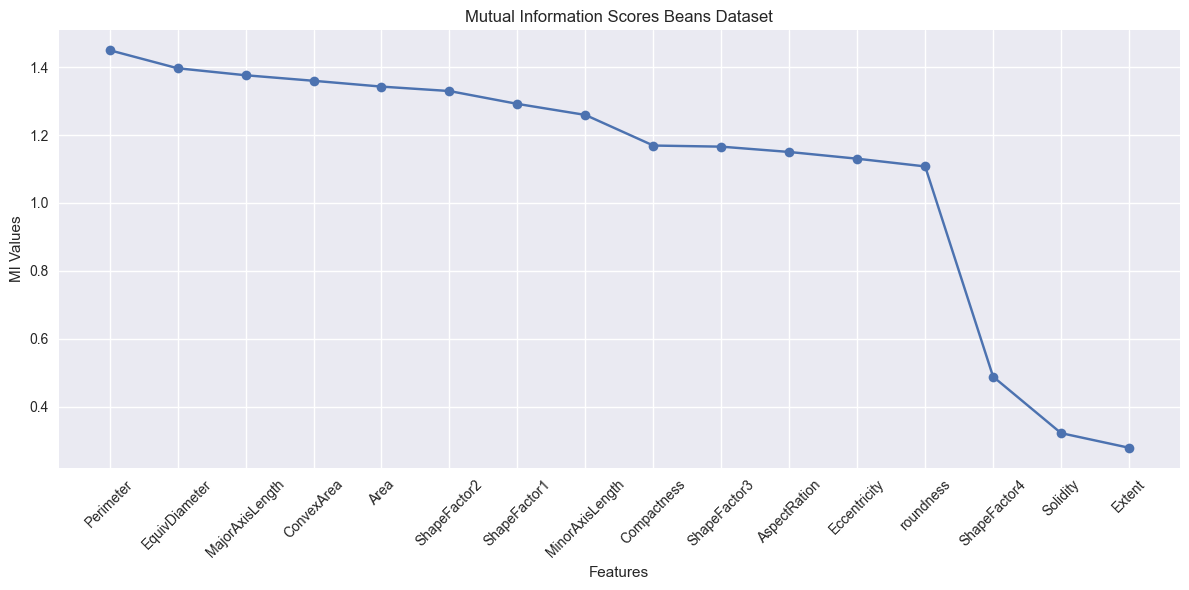

Part 0: [0 1 2 3 4]
Part 1: [5 6 7 8]
Part 2: [ 9 10 11 12]
Part 3: [13 14 15 16]
Target set shape: (13611, 4)
        Feature  MI_Score
0  ShapeFactor2  1.329859
1  ShapeFactor3  1.165966
2  ShapeFactor4  0.488105
        Feature   MI_Score
2  ShapeFactor4  17.110401
1  ShapeFactor3  16.449250
0  ShapeFactor2  12.081147


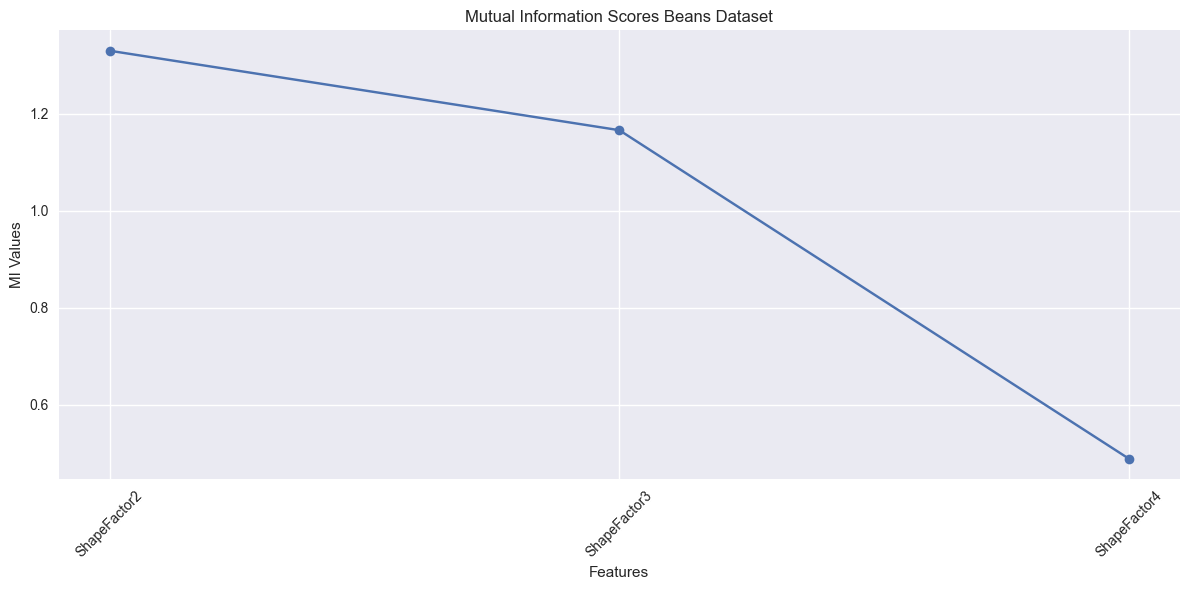

Column with lowest MI: ShapeFactor4
lowest_mi_data:0        13.0
1        13.0
2        13.0
3        10.0
4        13.0
         ... 
13606    13.0
13607    13.0
13608    12.0
13609    11.0
13610    13.0
Name: ShapeFactor4, Length: 13611, dtype: float64


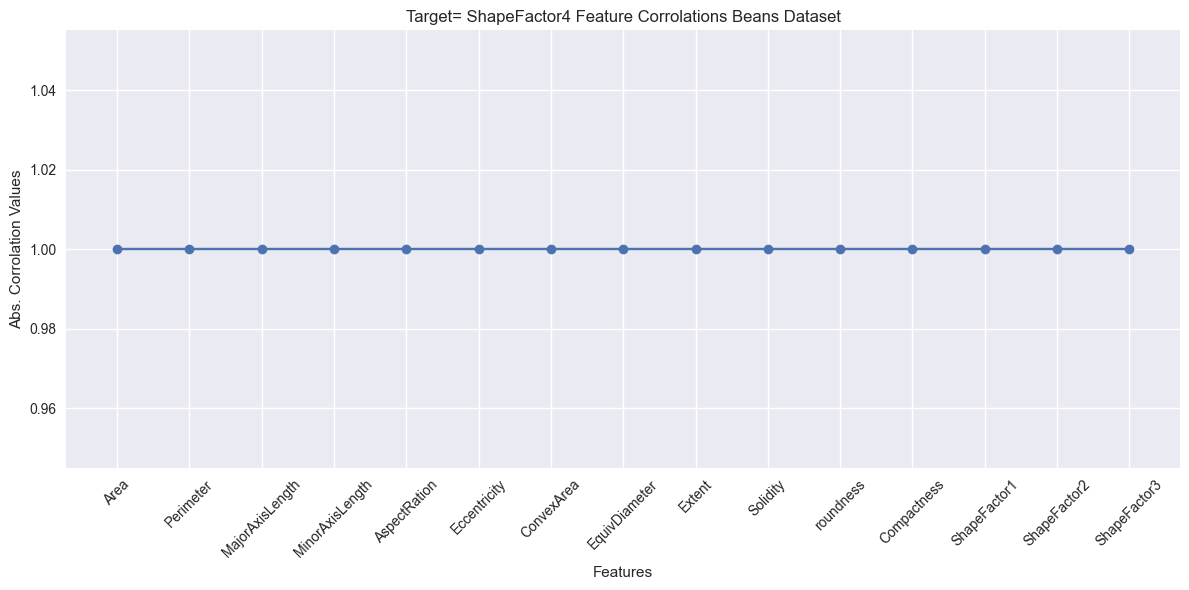

In [18]:
# DP parameters
epsilon_mi = 0.4
epsilon_corr = 0.4
delta = 1e-5
#remaining 0.2 is for exponential mechanism

def gaussian_sigma(epsilon, delta):
    return np.sqrt(2 * np.log(1.25 / delta)) / epsilon


def mi_for_all(df_name=df, lc=label_column, title='complete dataset',
               epsilon=epsilon_mi, delta=delta):

    y = df_name.iloc[:, lc]
    x = df_name.drop(df_name.columns[lc], axis=1)

    mi_scores = mutual_info_classif(
        x, y, discrete_features=True
    )

    mi_scores = mi_scores / np.log(2)

    mi_df = pd.DataFrame({
        "Feature": x.columns,
        "MI_Score": mi_scores
    }).sort_values(by="MI_Score", ascending=False)
    print(mi_df)
    # DP Gaussian noise
    sigma = gaussian_sigma(epsilon, delta)
    mi_scores = mi_scores + np.random.normal(0, sigma, size=len(mi_scores))

    dp_mi_df = pd.DataFrame({
        "Feature": x.columns,
        "MI_Score": mi_scores
    }).sort_values(by="MI_Score", ascending=False)
    print(dp_mi_df)
    # Create line plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(mi_df["Feature"], mi_df["MI_Score"], marker='o')
    ax.set_xlabel("Features")
    ax.set_ylabel("MI Values")
    ax.set_title(f"Mutual Information Scores {dataset_name.title()} Dataset")
    plt.style.use('seaborn-v0_8')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'mi {dataset_name} {title}.png', dpi=300, bbox_inches='tight')
    plt.show()



    return x, y, mi_df


x,y,mi_df= mi_for_all()


parts = np.array_split(np.arange(df.shape[1]), number_of_sets, axis=0)
for i, part in enumerate(parts):
    print(f"Part {i}: {part}")

target_set = None

# Find which part has the label column and get that part
for part in parts:
    if label_column in part:
        target_set = df.iloc[:, part]
        break

if target_set is not None:
    print(f"Target set shape: {target_set.shape}")
else:
    print(f"Label column {label_column} not found in any part")


#make label first column on target_set and the last column will be the lowst mi on target_set
label_col = df.columns[label_column]
col_data = target_set.pop(label_col)  # Remove the column
target_set.insert(0, label_col, col_data)  # Insert it at position 0


# Get MI scores and find lowest MI column
a,b,target_mi_df = mi_for_all(df_name=target_set, lc=0, title = 'in target set')

lowest_mi_column = target_mi_df.iloc[-1]['Feature']
print(f"Column with lowest MI: {lowest_mi_column}")

# Calculate Spearman correlations
lowest_mi_data = target_set[lowest_mi_column]
print(f"lowest_mi_data:{lowest_mi_data}")

#x_ranked = x.rank(method='average').astype(int)
#lowest_mi_ranked = lowest_mi_data.rank(method='average').astype(int)

correlations = x.corrwith(lowest_mi_data, method='spearman')

# DP Gaussian noise 
sigma_corr = gaussian_sigma(epsilon_corr, delta)
correlations = correlations + np.random.normal(
    0, sigma_corr, size=len(correlations)
)

# Optional clipping (post-processing, safe)
correlations = correlations.clip(-1.0, 1.0)

# Convert to DataFrame and sort
corr_df = pd.DataFrame({
    'Feature': correlations.index,
    'Spearman_Correlation': correlations.abs().values
}).sort_values('Spearman_Correlation',ascending=False)

# Remove the column that correlates with itself
corr_df = corr_df[corr_df['Feature'] != lowest_mi_column]


# Create line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(corr_df["Feature"], corr_df["Spearman_Correlation"], marker='o')
ax.set_xlabel("Features")
ax.set_ylabel("Abs. Corrolation Values")
ax.set_title(f"Target= {lowest_mi_column} Feature Corrolations {dataset_name.title()} Dataset")
plt.style.use('seaborn-v0_8')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{dataset_name} spearman correlation.png', dpi=300, bbox_inches='tight')
plt.show()

corr_df.to_latex(f'{dataset_name}_dp_corr.tex', index=True, float_format='%.6f')

Finding Spearman elbow

In [19]:
corr_df = corr_df.reset_index(drop=True)

print(corr_df)
corr_df['diffrence'] = corr_df['Spearman_Correlation'].diff(-1)
#corr_df['diffrence'] = corr_df['diffrence'] +1
print(corr_df)

corr_df["ratio"] = corr_df['diffrence'].shift(-1) / corr_df['diffrence']

#corr_df['ratio'] = corr_df['ratio'] -1
#corr_df['ratio'] = corr_df['ratio'] * 100

print(corr_df)

            Feature  Spearman_Correlation
0              Area                   1.0
1         Perimeter                   1.0
2   MajorAxisLength                   1.0
3   MinorAxisLength                   1.0
4      AspectRation                   1.0
5      Eccentricity                   1.0
6        ConvexArea                   1.0
7     EquivDiameter                   1.0
8            Extent                   1.0
9          Solidity                   1.0
10        roundness                   1.0
11      Compactness                   1.0
12     ShapeFactor1                   1.0
13     ShapeFactor2                   1.0
14     ShapeFactor3                   1.0
            Feature  Spearman_Correlation  diffrence
0              Area                   1.0        0.0
1         Perimeter                   1.0        0.0
2   MajorAxisLength                   1.0        0.0
3   MinorAxisLength                   1.0        0.0
4      AspectRation                   1.0        0.0
5      Ecc

In [20]:
corr_df = corr_df.reset_index(drop=True)
print(corr_df)
# 4th largest slope value
threshold = corr_df["ratio"].nlargest(4).iloc[-1]

# Search from top to bottom for first slope >= threshold
deterministic_elbow = corr_df[
    corr_df["ratio"] >= threshold
].index[0]

print("Deterministic elbow index:", deterministic_elbow)

            Feature  Spearman_Correlation  diffrence  ratio
0              Area                   1.0        0.0    NaN
1         Perimeter                   1.0        0.0    NaN
2   MajorAxisLength                   1.0        0.0    NaN
3   MinorAxisLength                   1.0        0.0    NaN
4      AspectRation                   1.0        0.0    NaN
5      Eccentricity                   1.0        0.0    NaN
6        ConvexArea                   1.0        0.0    NaN
7     EquivDiameter                   1.0        0.0    NaN
8            Extent                   1.0        0.0    NaN
9          Solidity                   1.0        0.0    NaN
10        roundness                   1.0        0.0    NaN
11      Compactness                   1.0        0.0    NaN
12     ShapeFactor1                   1.0        0.0    NaN
13     ShapeFactor2                   1.0        0.0    NaN
14     ShapeFactor3                   1.0        NaN    NaN


IndexError: index 0 is out of bounds for axis 0 with size 0

Implementing position based Exponential Mechanishm


):
def exponential_mechanism_position(corr_df, elbow_index, epsilon):
    d = len(corr_df)
    K = d // 4
    
    indices = np.arange(len(corr_df))
    mask = np.abs(indices - elbow_index) <= K
    candidate_indices = indices[mask]
    
    utilities = -np.abs(candidate_indices - elbow_index)
     
    # Exponential mechanism probabilities
    scores = np.exp((epsilon * utilities) / 2)
    probabilities = scores / scores.sum()
    
    sampled_index = np.random.choice(candidate_indices, p=probabilities)
    
    return sampled_index, probabilities, candidate_indices


# Applying the mechanism
epsilon = 1.0  # privacy budget for elbow selection

dp_elbow, probs, candidate_indices = exponential_mechanism_position(
    corr_df,
    deterministic_elbow,
    epsilon
)

print("DP elbow index:", dp_elbow)
print("Selected feature:", corr_df.loc[dp_elbow, "Feature"])



# probability mass
prob_df = corr_df.copy()
prob_df["probability"] = 0.0        # initialize all to zero
prob_df.iloc[candidate_indices, prob_df.columns.get_loc("probability")] = probs
prob_df["distance_to_elbow"] = abs(prob_df.index - deterministic_elbow)

prob_df.sort_values("probability", ascending=False)
